Created by Thomas Addisu Sæve Frette, Chi Nguyen and Elias Borge Svinø

# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Monday, October 21, 2024, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a Neural Network (MLP). This is similar to a problem you have worked on before but requires the use of a neural network model.

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/6610d6c6ba314eac9ead0b7a47695700
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  



> Good luck, comrade!

---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a neural network (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering. So the manual feature engineering is not allowed!
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Enhance performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning training hyperparameters.

> Note: There are no restrictions on the tricks you can use — just achieve the required accuracy. Stack more layers, use AdamW, scheduling, ect. Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How did you achieve the reproducibility of the results?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between the SGD and Adam optimizers.
   - Visualize the learning rate dynamics. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct an ablation study of each architectural and optimization choice concerning test accuracy.


In [3]:
# For network architecture visualization, other options are totally fine
from tensorflow.keras.utils import plot_model
from torchviz import make_dot

c:\Python310\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

FileNotFoundError: [Errno 2] No such file or directory: 'nn_data.csv'

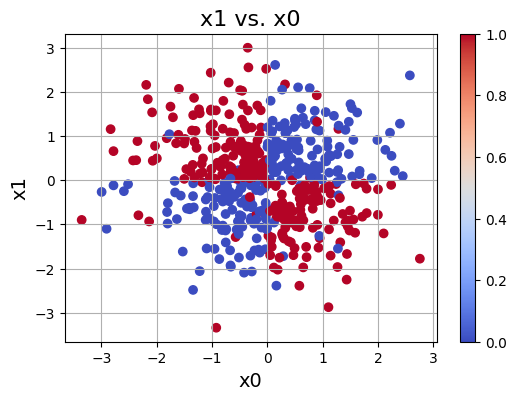

In [5]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()


In [94]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import math
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Call this function at the start of your script
set_seed(12)

# Splitting data into training and testing sets
train_data = data[data['split'] == 'train']
test_data = data[data['split'] == 'test']

# Extracting features and labels for training and testing
X_train = torch.tensor(train_data[['x0', 'x1']].values, dtype=torch.float32)
y_train = torch.tensor(train_data['y'].values, dtype=torch.float32).unsqueeze(1)

X_test = torch.tensor(test_data[['x0', 'x1']].values, dtype=torch.float32)
y_test = torch.tensor(test_data['y'].values, dtype=torch.float32).unsqueeze(1)

# Creating DataLoader for batching
batch_size = 128

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the custom learning rate scheduler
class CosineWarmupScheduler:
    def __init__(self, optimizer, warmup_epochs, total_epochs, base_lr, min_lr=1e-6):
        self.optimizer = optimizer
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.base_lr = base_lr
        self.min_lr = min_lr
        self.epoch = 0
    
    def step(self):
        if self.epoch < self.warmup_epochs:
            # Linear warmup
            lr = self.base_lr * (self.epoch + 1) / self.warmup_epochs
        else:
            # Cosine decay after warmup
            progress = (self.epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.min_lr + 0.5 * (self.base_lr - self.min_lr) * (1 + math.cos(math.pi * progress))
        
        # Update the optimizer's learning rate
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        
        self.epoch += 1
        print(f"Epoch {self.epoch}: Learning Rate {lr}")

# Define the MLP model with BatchNorm and Dropout
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return self.sigmoid(x)

# Xavier Initialization for better convergence
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

# Instantiate the model and initialize weights
model = MLP()
model.apply(initialize_weights)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Instantiate the scheduler
warmup_epochs = 10
total_epochs = 150
base_lr = 0.0001
scheduler = CosineWarmupScheduler(optimizer, warmup_epochs, total_epochs, base_lr)



# Training loop with manual learning rate scheduler
def train_model(model, train_loader, optimizer, scheduler, criterion, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
        
        # Update the learning rate manually with the scheduler
        scheduler.step()

        # Print training progress
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            predicted = (outputs > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')

# Train the model
train_model(model, train_loader, optimizer, scheduler, criterion, epochs=total_epochs)

# Evaluate the model
evaluate_model(model, test_loader)



Epoch 1: Learning Rate 1e-05
Epoch 1/150, Loss: 0.805232584476471
Epoch 2: Learning Rate 2e-05
Epoch 2/150, Loss: 0.7259294986724854
Epoch 3: Learning Rate 3.0000000000000004e-05
Epoch 3/150, Loss: 0.7793701887130737
Epoch 4: Learning Rate 4e-05
Epoch 4/150, Loss: 0.8116601705551147
Epoch 5: Learning Rate 5e-05
Epoch 5/150, Loss: 0.8374587893486023
Epoch 6: Learning Rate 6.000000000000001e-05
Epoch 6/150, Loss: 0.7588180303573608
Epoch 7: Learning Rate 7e-05
Epoch 7/150, Loss: 0.8021417856216431
Epoch 8: Learning Rate 8e-05
Epoch 8/150, Loss: 0.6893090605735779
Epoch 9: Learning Rate 9e-05
Epoch 9/150, Loss: 0.6462801098823547
Epoch 10: Learning Rate 0.0001
Epoch 10/150, Loss: 0.5487409830093384
Epoch 11: Learning Rate 0.0001
Epoch 11/150, Loss: 0.5570769309997559
Epoch 12: Learning Rate 9.998753762965408e-05
Epoch 12/150, Loss: 0.5422301292419434
Epoch 13: Learning Rate 9.995015679379509e-05
Epoch 13/150, Loss: 0.6191232800483704
Epoch 14: Learning Rate 9.988787631479958e-05
Epoch 14/

# Discussion 

  ### How did you achieve the reproducibility of the results?

We achieved reproducable results by setting the seed at the beginning of the operation. This ensures that the weights and constants relevant to the neural network are not created randomly every time, but a fixed value.



   ### Visualize the network's architecture and decision boundary.

   


In [98]:
from torchsummary import summary
summary(model, input_size=(2,))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]             768
       BatchNorm1d-2                  [-1, 256]             512
           Dropout-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
       BatchNorm1d-5                  [-1, 128]             256
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 1]             129
           Sigmoid-8                    [-1, 1]               0
Total params: 34,561
Trainable params: 34,561
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.13
Estimated Total Size (MB): 0.14
----------------------------------------------------------------


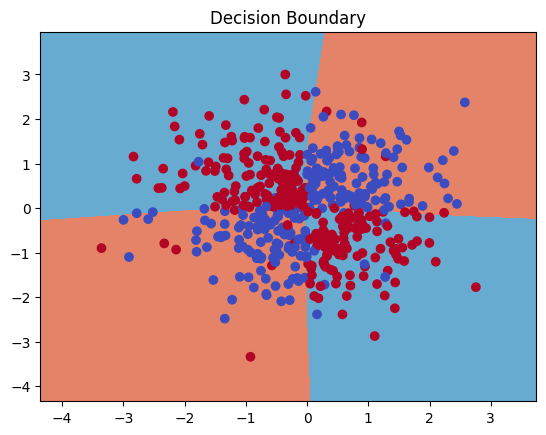

In [99]:
import matplotlib.pyplot as plt
import numpy as np

x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
Z = model(grid_points).detach().numpy().reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], cmap='RdBu')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm')
plt.title("Decision Boundary")
plt.show()

   ### Which optimizer did you choose? Discuss the differences between the SGD and Adam optimizers.

We chose to use Adam because it has faster convergence and an adaptive learning rate. 

While SGD updates the weights based on a single learning rate, Adam adjusts the learning rate for each parameter. Even though SGD has slower convergence, it can lead to better generalization. 
All in all Adam was selected for its faster convergence and the fact that it modifies the learning rate.

   ### Visualize the learning rate dynamics. Did the learning rate scheduling improve performance? Why or why not?
   


Epoch 151: Learning Rate 1e-06
Epoch 152: Learning Rate 1.0124623703459267e-06
Epoch 153: Learning Rate 1.0498432062049224e-06
Epoch 154: Learning Rate 1.1121236852004183e-06
Epoch 155: Learning Rate 1.1992724472356662e-06
Epoch 156: Learning Rate 1.3112456102844967e-06
Epoch 157: Learning Rate 1.4479867924872268e-06
Epoch 158: Learning Rate 1.6094271405406804e-06
Epoch 159: Learning Rate 1.7954853643678315e-06
Epoch 160: Learning Rate 2.0060677780498385e-06
Epoch 161: Learning Rate 2.2410683469997307e-06
Epoch 162: Learning Rate 2.5003687413539994e-06
Epoch 163: Learning Rate 2.7838383955552538e-06
Epoch 164: Learning Rate 3.091334574095932e-06
Epoch 165: Learning Rate 3.4227024433899e-06
Epoch 166: Learning Rate 3.777775149735805e-06
Epoch 167: Learning Rate 4.156373903333003e-06
Epoch 168: Learning Rate 4.558308068307572e-06
Epoch 169: Learning Rate 4.983375258703191e-06
Epoch 170: Learning Rate 5.4313614403886095e-06
Epoch 171: Learning Rate 5.902041038830253e-06
Epoch 172: Learnin

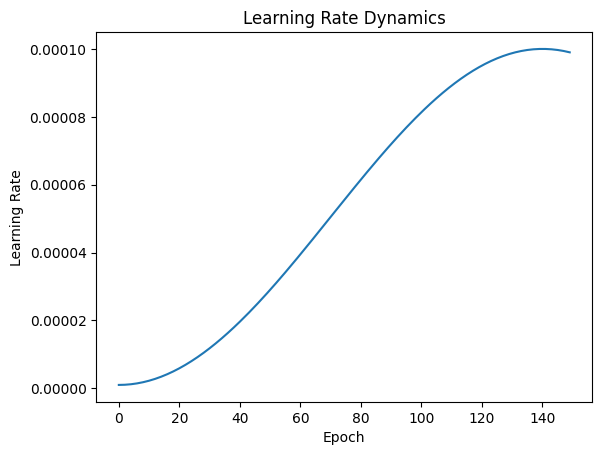

In [100]:
lrs = []
for epoch in range(total_epochs):
    scheduler.step()
    lrs.append(scheduler.optimizer.param_groups[0]['lr'])

plt.plot(lrs)
plt.title("Learning Rate Dynamics")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.show()


   ### Conduct an ablation study of each architectural and optimization choice concerning test accuracy.

   To perform the ablation study we removed certain parts of the implementation and reviewed how well the nn-model performed. 
   As the process of structuring the model was a stepwise process, we tested removing some of the techniques we implemented to improve the accuracy.

   ps. we weren't entirely sure of how to perform this study so it might be a bit off hehe.

##### Ablation Study Results:
**Dropout:**

With Dropout (0.4): 91,2% accuracy
Without Dropout: 90,1% accuracy


**Batch Normalization:**

With Batch Norm: 91,4% accuracy
Without Batch Norm: 90% accuracy


**L2 Regularization: In Adam: Weight Decay**

With weight decay: 92% accuracy
Without Scheduler: 91,4% accuracy

**Choice of optimizer:**

Adam: 91,2% accuracy
SGD: 88,5% accuracy

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts (~30 days * 50 submissions = 1500 total attempts per student).

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/6610d6c6ba314eac9ead0b7a47695700)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.


In [4]:
import pandas as pd

data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)

In [71]:
data

,ID,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0,0.314365,0.646305,0.323849,0.238492,0.655790,0.646305,0.646305,0.409205,0.646305,...,0.646305,0.646305,0.655790,0.238492,0.646305,0.674758,0.646305,0.238492,0.655790,0.646305
1,1,0.587628,0.494976,0.559832,-0.246237,0.513506,0.550567,0.522772,0.596893,0.606158,...,0.587628,0.550567,0.587628,0.587628,0.550567,0.587628,0.550567,0.596893,0.494976,0.587628
2,2,0.590203,0.367673,0.367673,0.367673,0.367673,0.590203,0.367673,0.590203,0.590203,...,0.590203,0.367673,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.476556
3,3,0.589296,0.589296,0.579825,0.551415,0.579825,0.579825,0.608236,0.579825,0.646118,...,0.532474,0.523003,0.589296,0.589296,0.551415,0.134721,0.475652,0.589296,0.570355,0.551415
4,4,0.660095,0.470676,0.190366,0.672806,0.470761,0.672766,0.672652,0.666151,0.672987,...,0.432001,0.672222,0.190568,0.217329,0.633684,0.673294,0.587914,0.671023,0.207578,0.470765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.340739,0.340739,0.340739,0.681823,0.340739,0.340739,0.340739,0.672083,0.340739,...,0.340739,0.662355,0.340739,0.759779,0.331011,0.759779,0.340739,0.691563,0.340734,0.720789
3996,3996,0.384257,0.384257,0.675221,0.384257,0.384257,0.675221,0.384257,0.675221,0.675221,...,0.675221,0.384257,0.675221,0.675221,0.675221,0.384257,0.384257,0.384257,0.675221,0.675221
3997,3997,0.641837,0.651135,0.251329,0.251329,0.651135,0.651135,0.251329,0.651135,0.651135,...,0.251329,0.251329,0.651135,0.251329,0.409392,0.604646,0.651135,0.651135,0.660433,0.251329
3998,3998,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,-0.212897,0.555533,...,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533


In [72]:
# The dataset is heavy. Applying clustering directly on the dataset is not feasible, I guess. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


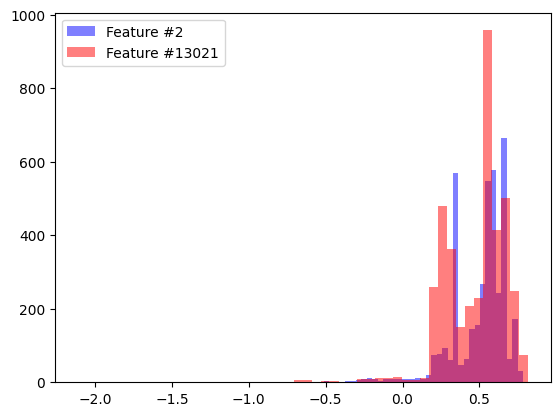

In [6]:
import matplotlib.pyplot as plt
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()

In [14]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
print(sample_submission)

submission = pd.read_csv('cluster_submission.csv')
print(submission)

        ID  cluster
0        0        2
1        1        6
2        2        3
3        3        3
4        4        8
...    ...      ...
3995  3995        3
3996  3996        7
3997  3997        3
3998  3998        7
3999  3999        2

[4000 rows x 2 columns]
        ID  Cluster_Labels
0        0               0
1        1               1
2        2               2
3        3               1
4        4               3
...    ...             ...
3995  3995               8
3996  3996               5
3997  3997               2
3998  3998               9
3999  3999               7

[4000 rows x 2 columns]


In [38]:

import umap.umap_ as umap

umap_reduction = umap.UMAP(n_neighbors=30, random_state=42)
umap_results = umap_reduction.fit_transform(data.iloc[:, 1:])

plt.scatter(umap_results[:, 0], umap_results[:, 1], c=data.iloc[:, 0], cmap='coolwarm')
plt.show()

c:\Python310\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


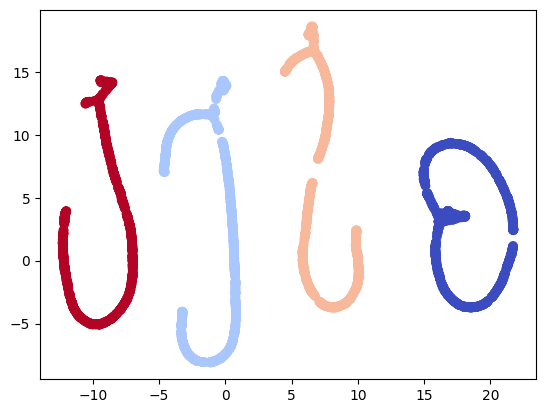

In [30]:
from sklearn.cluster import DBSCAN

dbscan_model = DBSCAN(eps=3.4, min_samples=10)
dbscan_results_umap = dbscan_model.fit_predict(umap_results)
plt.scatter(umap_results[:, 0], umap_results[:, 1], c=dbscan_results_umap, cmap='coolwarm')
plt.show()

In [9]:
# Create a DataFrame for submission
dbscan_results_umap = pd.DataFrame({
    'ID': data['ID'],   # Use the original ID column
    'cluster': dbscan_results_umap
})

# Save the clustering results to CSV for Kaggle submission or further analysis
dbscan_results_umap.to_csv('cluster_submission.csv', index=False)



---

## 🎯 Note: Clustering Accuracy Evaluation


The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation focuses solely on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [56]:
from typing import Any
import numpy as np
import sklearn.metrics
import scipy.optimize

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy


In [57]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

1.0

In [65]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.3333333333333333

In [67]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.5

# Discussion

**Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.

* We used UMAP as the dimensionality reduction method to help determine the correct number of clusters. UMAP seemed to work better than PCA and t-SNE because it captures both local and global structures in the data, making the clusters more visible. PCA is more focused on preserving variance, which is not always ideal for clustering, while t-SNE is great for visualizing high-dimensional data but struggles with large datasets and often distorts global relationships.

**Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
* We used DBSCAN with eps=3.4 and min_samples=10. DBSCAN is good because it can detect clusters of different shapes and sizes, and it handles noise well. In contrast, KMeans requires you to predefine the number of clusters and works best with spherical clusters. DBSCAN was more flexible for the kind of clusters we expected to find.





**Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.

Below we have sorted the data, and translated it into an image. 
Just for fun i printed out the first 20 rows and can see that many images are variants of the same location. 

From the clusters we assume that there is 4 server locations. 

From the images we can see that these locations are: 
* Pirbadet
* Trondheim Spektrum
* StudenterSamfundet
* Ikea Leangen

In [ ]:


data = pd.read_csv('unsupervised_data.csv')
# remove col_ from column names
data.columns = data.columns.str.replace('col_', '')
data = data.sort_index(axis=1, key=lambda x: x.astype(int))


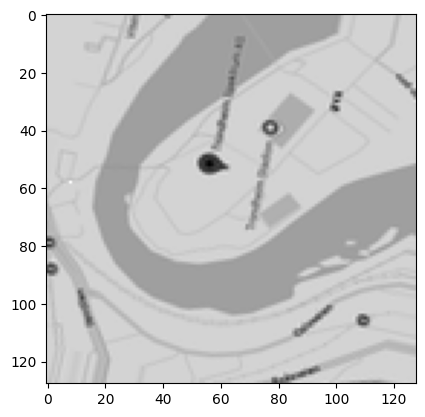

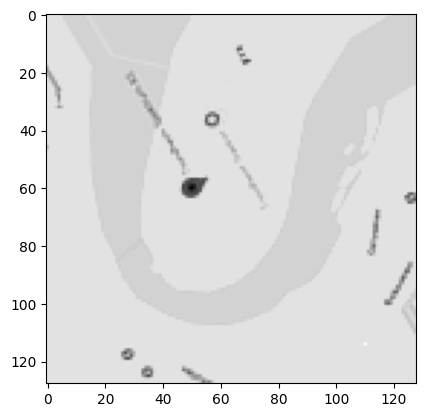

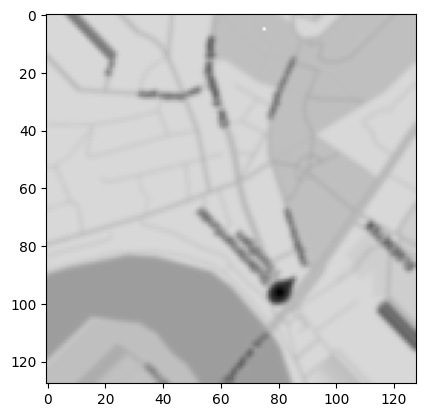

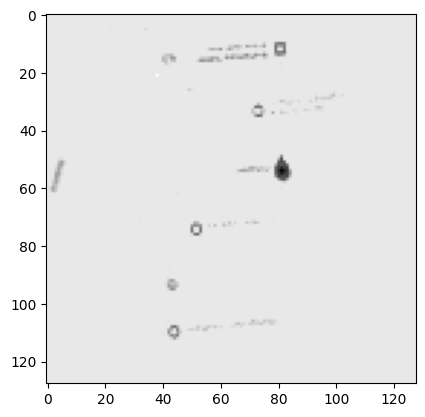

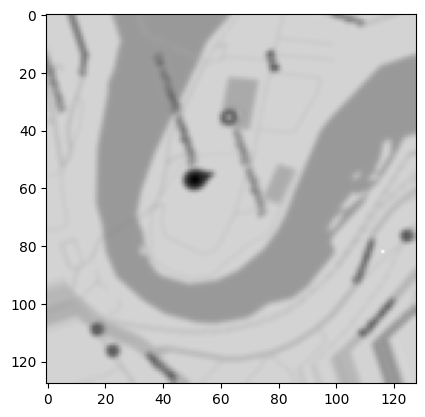

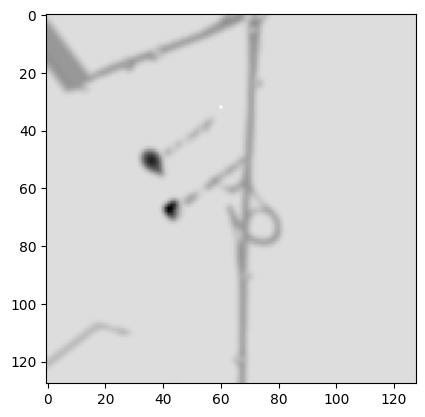

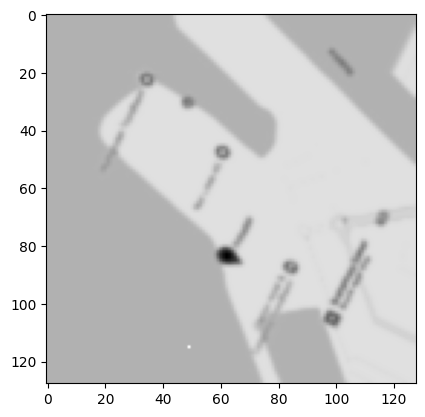

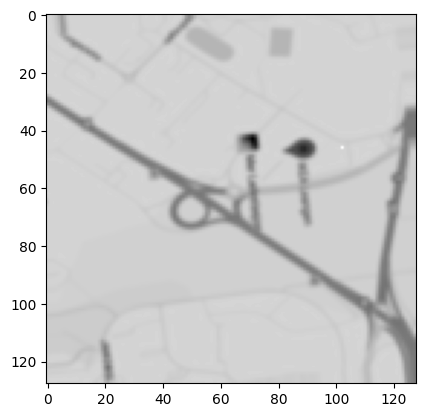

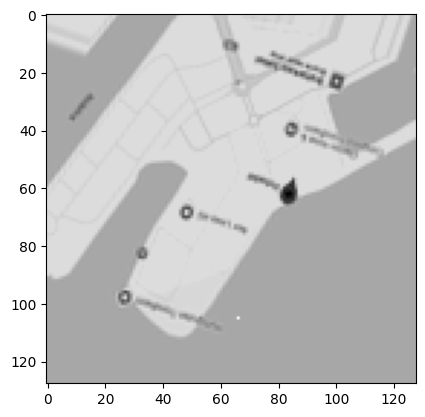

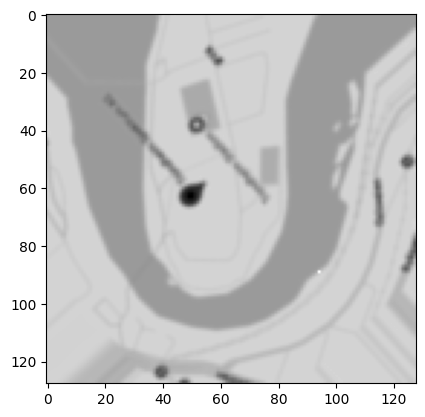

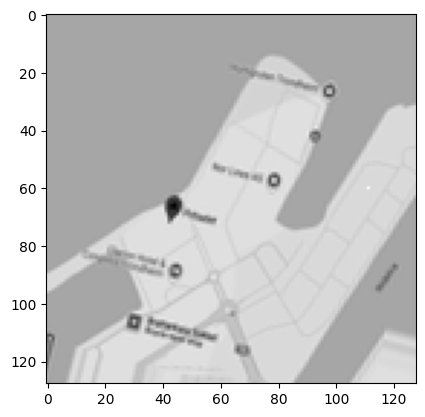

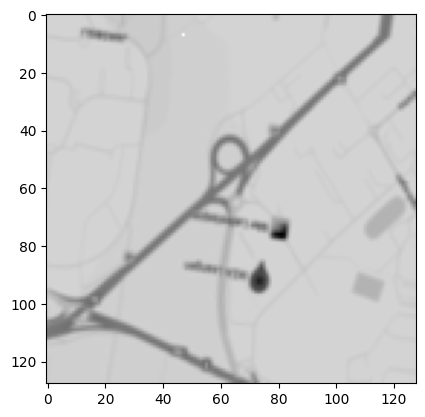

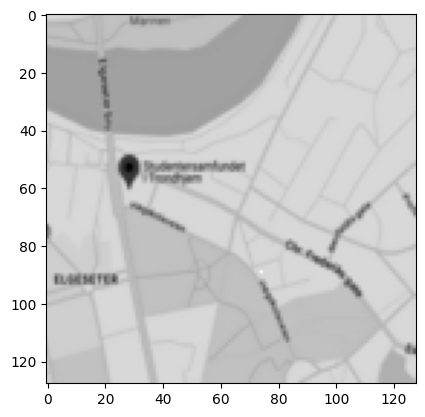

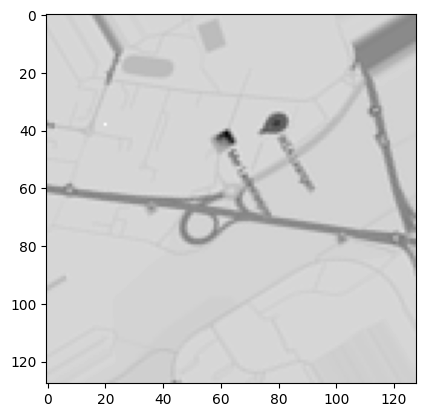

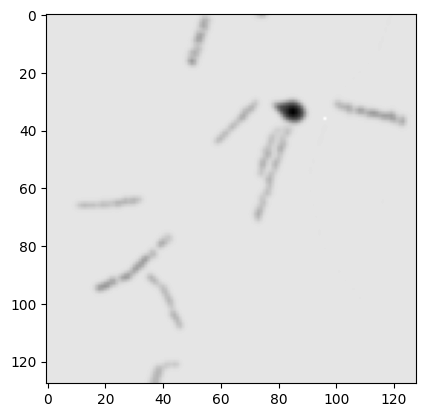

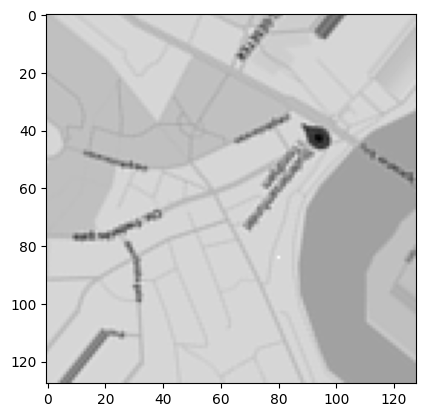

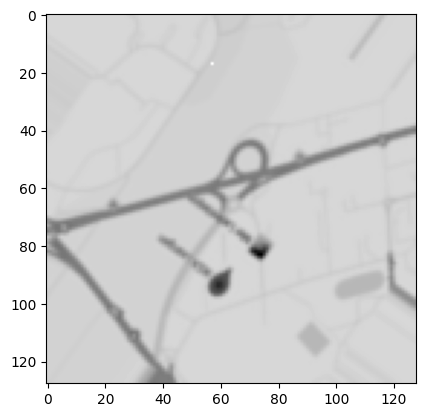

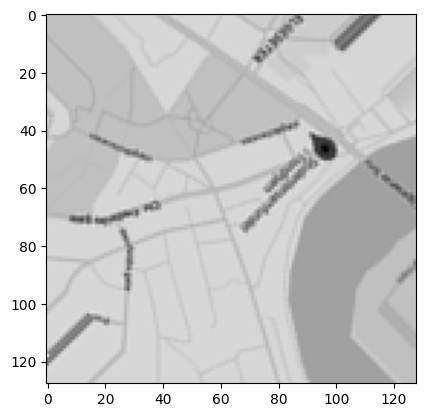

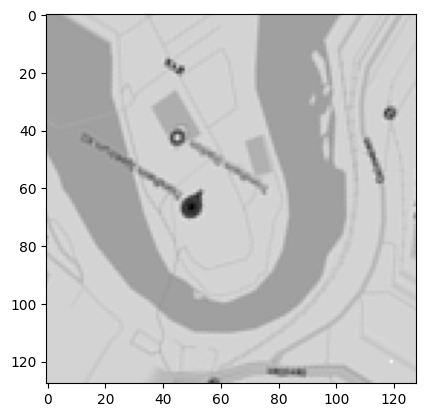

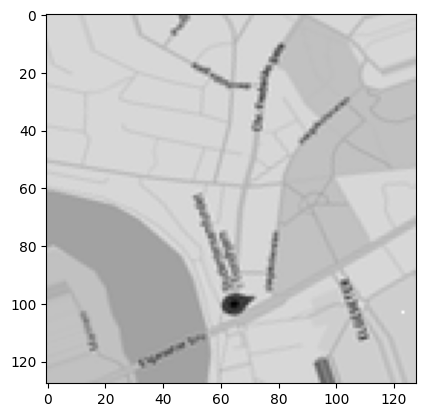

In [176]:
import matplotlib.pyplot as plt


for i in range(20):
    random_row = data.iloc[i*2]
    plotting = random_row.values.reshape(128, 128)
    plt.imshow(plotting, cmap='gray')
    plt.show()




**Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?

* The data reveals an image so the data is some kind of geolocation data. Therefore the data is probably very dependent on data in close proximity and feature extraction can modify this. I think dimensionality reducion is more effective because it doesnt remove or shuffle the data, it just makes it more easy to work with. 

**Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

* DNF
